In [ ]:
pip install plotly

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
from google.colab import files

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.cm import get_cmap
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import os
import nltk
from scipy.stats import f_oneway
import tensorflow as tf

from tqdm import tqdm

**This notebook contains a comprehensive Exploratory Data Analysis (EDA) conducted for this project. Here, you'll find detailed information and insights derived from our data, including:**

1. Data Cleaning: A description of any data cleaning steps performed

2. Descriptive Statistics: Summary statistics (mean, median, mode, etc.) and visualizations to understand the distribution of key variables.

3. Feature Exploration: Analysis of individual features and their relationships with other variables, including visualizations like histograms, scatter plots, etc.

4. Key Findings: A summary of the most important insights gained from the EDA, highlighting any patterns, trends, or anomalies discovered in the data.

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/RecSys Competition data'

Mounted at /content/drive


## **Load datasets**

In [ ]:
movies_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/movies.csv')
ratings_submission_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/ratings_submission.csv')
tags_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/tags.csv')
train_df = pd.read_csv('/content/drive/My Drive/RecSys Competition data/train.csv')

tags_df["movie_id"] = tags_df["movie_id"].astype(int)
tags_df["user_id"] = tags_df["user_id"].astype(int)

unrated_df = train_df[train_df['rating'].isnull()]
rated_df = train_df[train_df['rating'].notnull()]

## **Movies**

In [ ]:
movies_df.head(5)

,movie_id,title,genres
0,11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,8,Jumanji (1995),Adventure|Children|Fantasy
2,9,Grumpier Old Men (1995),Comedy|Romance
3,15,Father of the Bride Part II (1995),Comedy
4,12,Heat (1995),Action|Crime|Thriller


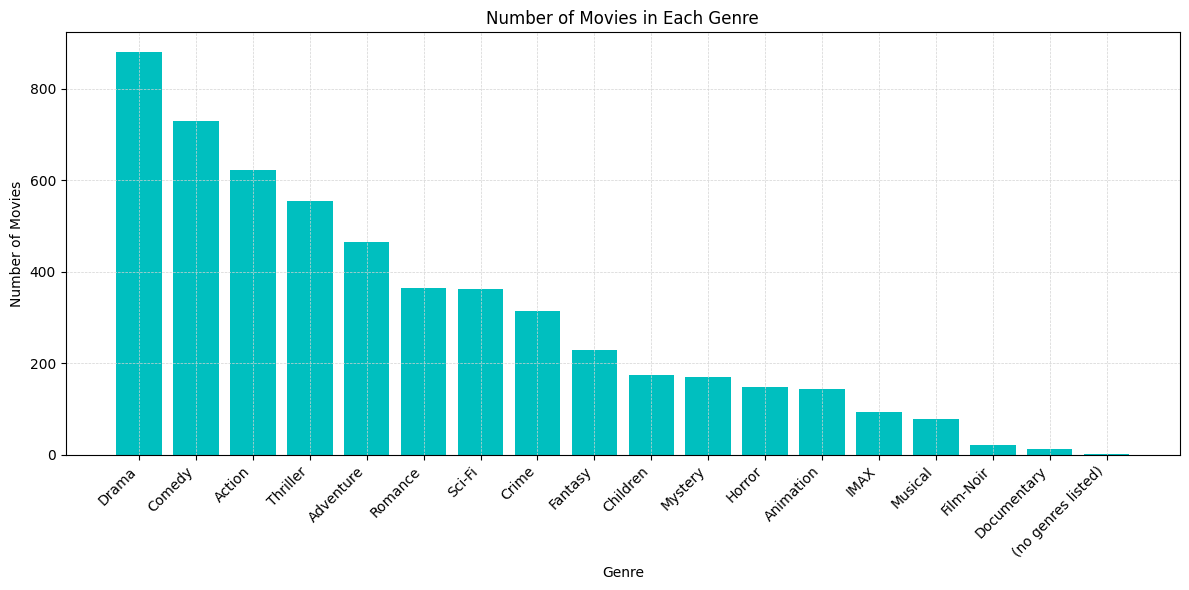

In [ ]:
# Split the 'genres' column into individual genres
genres_split_df = movies_df['genres'].str.get_dummies(sep='|')

# Combine the original DF with the one-hot encoded genres
movies_with_genres = pd.concat([movies_df, genres_split_df], axis=1)

# sum up the one-hot encoded genre col
genre_counts = movies_with_genres.iloc[:, 3:-2].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values, color = 'c')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()

In [ ]:
def preprocess_movie_df(movies_df: pd.DataFrame) -> pd.DataFrame:
  # Genres:
  genres_split_df = movies_df['genres'].str.get_dummies(sep='|')
  genres_split_df.columns = genres_split_df.columns.str.lower()

  # Combine the original DF with the one-hot encoded genres
  movies_with_genres = pd.concat([movies_df, genres_split_df], axis=1)
  movies_with_genres['num_genres'] = movies_with_genres.iloc[:, 3:].sum(axis=1)

  # Year field:
  movies_with_genres['year'] = movies_with_genres['title'].str.extract(r'\((\d{4})\)').astype('Int64')

  # Add year of two missing movies (info found in Google)
  movies_with_genres.loc[movies_with_genres["title"]=="Ready Player One", "year"] = 2018
  movies_with_genres.loc[movies_with_genres["title"]=="Moonlight", "year"] = 2016

  # Standardizing year field with a standard normal distribution (mu=0, std=1)
  year_mean = movies_with_genres['year'].mean()
  year_std = movies_with_genres['year'].std()

  # Title field:
  # Strip off year from title, example: 'Toy Story (1995)' -> 'Toy Story'
  movies_with_genres['title'] = movies_with_genres['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)
  movies_with_genres['title'] = movies_with_genres['title'].str.strip()

  # Removing redundant columns
  movies_with_genres.drop(columns=['genres'], inplace=True)
  return movies_with_genres

In [ ]:
movies_with_genres = preprocess_movie_df(movies_df)

### corr between genre_columns and reaging

In [ ]:
# Combine genres into a single feature
genre_columns = ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary',
                 'drama', 'fantasy', 'horror', 'imax', 'musical', 'mystery', 'romance',
                 'sci-fi', 'thriller', 'war', 'western']

movies_with_genres['genre_combination'] = movies_with_genres[genre_columns].apply(
    lambda row: ' | '.join(col for col, val in zip(genre_columns, row) if val == 1), axis=1
)

In [ ]:
unrated_df = train_df[train_df['rating'].isnull()]
rated_df = train_df[train_df['rating'].notnull()]

In [ ]:
print(f'Number of rated movies: {len(rated_df)}')
print(f'Number of unrated movies: {len(unrated_df)}')

Number of rated movies: 7303350
Number of unrated movies: 11017969


In [ ]:
merged_df = pd.merge(rated_df, movies_with_genres[['movie_id', 'genre_combination']], on='movie_id', how='inner')

In [ ]:
genre_rating_stats = merged_df.groupby('genre_combination').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Sort by average rating
genre_rating_stats = genre_rating_stats.sort_values(by='avg_rating', ascending=False)
print(genre_rating_stats)

                                     genre_combination  avg_rating  \
74   action | adventure | mystery | romance | thriller    4.188723   
228                    adventure | animation | fantasy    4.182250   
43       action | adventure | crime | drama | thriller    4.162335   
121                      action | crime | drama | imax    4.156335   
480                                 romance | thriller    4.147685   
..                                                 ...         ...   
92                         action | children | romance    2.216251   
416      drama | fantasy | horror | romance | thriller    2.200625   
21               action | adventure | children | drama    2.169781   
330                         children | comedy | sci-fi    2.118060   
20   action | adventure | children | comedy | fanta...    2.034545   

     rating_count  
74           6083  
228          9465  
43           7041  
121         15422  
480          1879  
..            ...  
92           1163  

In [ ]:
# Perform ANOVA test
anova_result = f_oneway(*[group['rating'].values for _, group in merged_df.groupby('genre_combination')])
print(f"ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

ANOVA F-statistic: 1171.2638129239285, p-value: 0.0


The results of your ANOVA test indicate the following:

F-statistic: 1171.26: This is a high value, suggesting that there is a substantial variation in the mean ratings across different genre combinations.
p-value: 0.0: This indicates that the differences in mean ratings across genre combinations are statistically significant, as the p-value is below any common significance level (e.g., 0.05, 0.01).
Interpretation
The genre combinations have a significant effect on the average movie ratings. This means that certain genre combinations tend to be associated with higher or lower ratings compared to others.


In [ ]:
# Filter for genre combinations with sufficient ratings (e.g., > 50 ratings)
min_ratings = 50
filtered_genre_stats = genre_rating_stats[genre_rating_stats['rating_count'] > min_ratings]

# Top 10 genre
top_genres = filtered_genre_stats.nlargest(10, 'avg_rating')

# Bottom 10 genre
bottom_genres = filtered_genre_stats.nsmallest(10, 'avg_rating')

print("Top 10 Genre Combinations by Average Rating:")
top_genres

Top 10 Genre Combinations by Average Rating:


,genre_combination,avg_rating,rating_count
74,action | adventure | mystery | romance | thriller,4.188723,6083
228,adventure | animation | fantasy,4.182250,9465
43,action | adventure | crime | drama | thriller,4.162335,7041
121,action | crime | drama | imax,4.156335,15422
480,romance | thriller,4.147685,1879
297,animation | children | drama | fantasy,4.144775,4096
13,action | adventure | animation | drama | fantasy,4.143213,5422
84,action | adventure | western,4.137105,7239
60,action | adventure | drama | western,4.135632,1987
473,mystery,4.134077,4214


In [ ]:
print("\nBottom 10 Genre Combinations by Average Rating:")
bottom_genres


Bottom 10 Genre Combinations by Average Rating:


,genre_combination,avg_rating,rating_count
20,action | adventure | children | comedy | fanta...,2.034545,1954
330,children | comedy | sci-fi,2.118060,1567
21,action | adventure | children | drama,2.169781,1231
416,drama | fantasy | horror | romance | thriller,2.200625,1281
92,action | children | romance,2.216251,1163
459,fantasy | imax | romance | thriller,2.259720,1286
68,action | adventure | fantasy | thriller,2.272770,5325
115,action | comedy | sci-fi | western,2.321023,4224
422,drama | fantasy | romance | thriller,2.354519,2722
236,adventure | children | comedy | fantasy | mystery,2.368918,1377


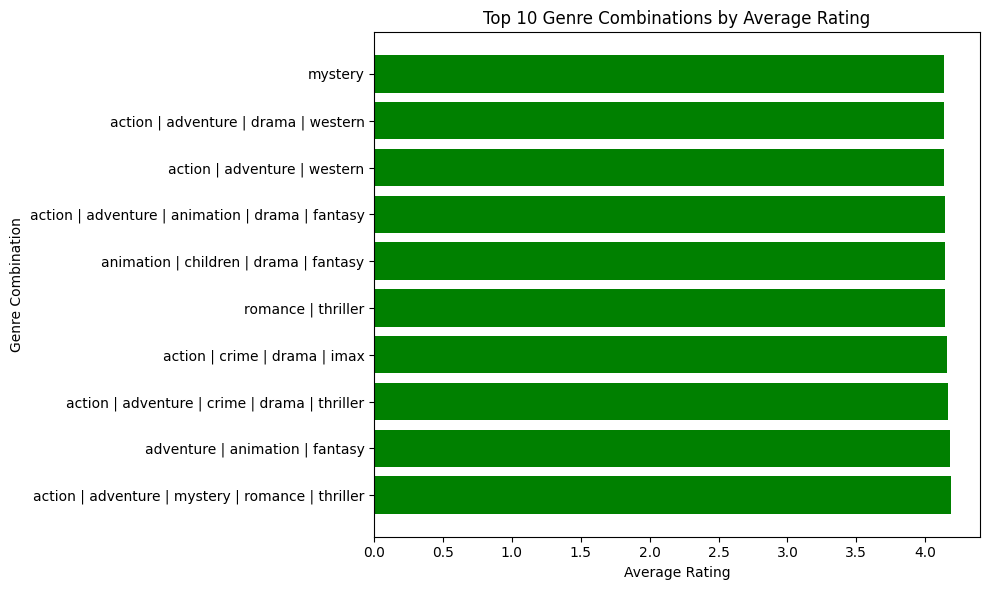

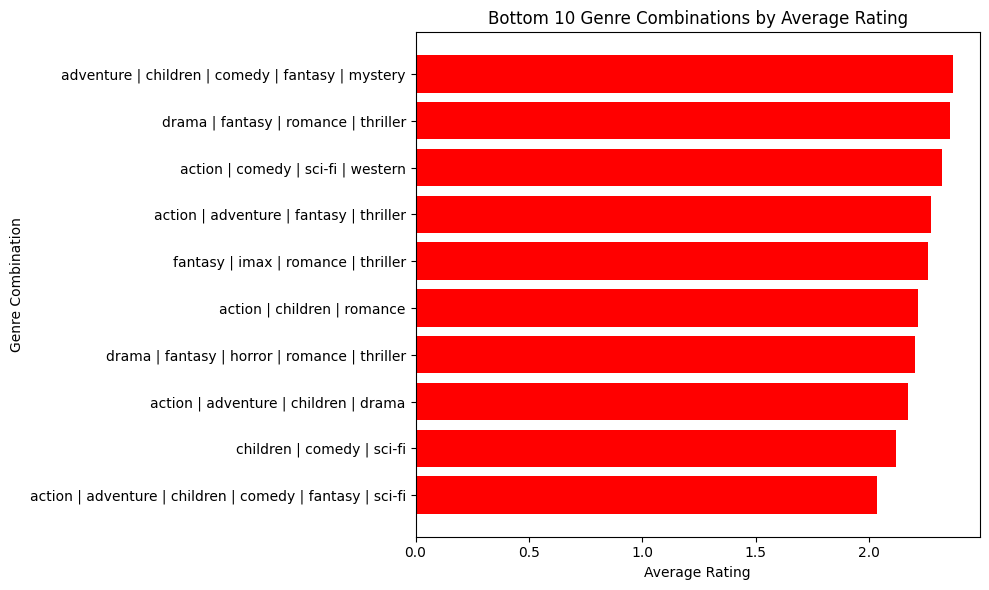

In [ ]:
# Plot Top 10 Genre Combinations
plt.figure(figsize=(10, 6))
plt.barh(top_genres['genre_combination'], top_genres['avg_rating'], color='green')
plt.xlabel('Average Rating')
plt.ylabel('Genre Combination')
plt.title('Top 10 Genre Combinations by Average Rating')
plt.tight_layout()
plt.show()

# Plot Bottom 10 Genre Combinations
plt.figure(figsize=(10, 6))
plt.barh(bottom_genres['genre_combination'], bottom_genres['avg_rating'], color='red')
plt.xlabel('Average Rating')
plt.ylabel('Genre Combination')
plt.title('Bottom 10 Genre Combinations by Average Rating')
plt.tight_layout()
plt.show()

## **Train**

In [ ]:
train_df.head(5)

,user_id,movie_id,rating
0,0,0,NaN
1,0,8,NaN
2,0,11,NaN
3,0,25,NaN
4,0,31,2.0


In [ ]:
# check for duplications
num_duplicated = train_df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicated}")

Number of duplicated rows: 0


### User bias

In [ ]:
# Calc the global AVG rating
global_avg_rating = rated_df['rating'].mean()

# Cakc the AVG rating for each user
user_avg_ratings = rated_df.groupby('user_id')['rating'].mean()

user_biases = user_avg_ratings - global_avg_rating
unique_users = rated_df['user_id'].unique()
unique_users = unique_users.astype(str)

In [ ]:
# Align biases with user indices
user_lookup = tf.keras.layers.StringLookup(vocabulary=unique_users, mask_token=None)
user_bias_array = np.zeros(len(unique_users))  # Initialize to zeros

for user_id, bias in user_biases.items():
    index = user_lookup(str(user_id)).numpy()
    user_bias_array[index-1] = bias

## **Tags**

In [ ]:
tags_df.head(5)

,user_id,movie_id,tag
0,28,79586,misogyny
1,40,2164,music
2,40,2164,weird
3,48,7441,bullying
4,48,7441,clique


In [ ]:
def preprocess_tags_df(tags_df: pd.DataFrame) -> pd.DataFrame:
  nltk.download('wordnet')
  nltk.download('omw-1.4')
  nltk.download('averaged_perceptron_tagger_eng')

  # Init the lemmatizer
  lemmatizer = nltk.WordNetLemmatizer()

  # Remove rows with invalid tags
  null_tags = tags_df["tag"].isnull()
  empty_tags = tags_df["tag"] == ""
  whitespace_tags = tags_df["tag"].str.strip() == ""
  invalid_tags = null_tags | empty_tags | whitespace_tags
  tags_df = tags_df[~invalid_tags]

  # Normalize tag text (convert to lowercase)
  tags_df["tag"] = tags_df["tag"].str.lower()

  # Function to convert POS tag from NLTK format to WordNet format
  def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
      return 'v'  # Verb
    elif treebank_tag.startswith('N'):
      return 'n'  # Noun
    elif treebank_tag.startswith('R'):
      return 'r'  # Adverb
    elif treebank_tag.startswith('J'):
      return 'a'  # Adjective
    else:
      return 'n'  # Default to noun

  def lemmatize_tag(tag):
    pos_tags = nltk.pos_tag(tag.split())
    return " ".join([lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in pos_tags])

  tags_df["tag"] = tags_df["tag"].apply(lemmatize_tag)
  return tags_df

In [ ]:
new_tags_df = preprocess_tags_df(tags_df)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
<ipython-input-7-c7696b355054>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_df["tag"] = tags_df["tag"].str.lower()
<ipython-input-7-c7696b355054>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_df["tag"

<ipython-input-13-5f3f4f523ce1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='Stage', y='Unique Tags', palette='viridis')


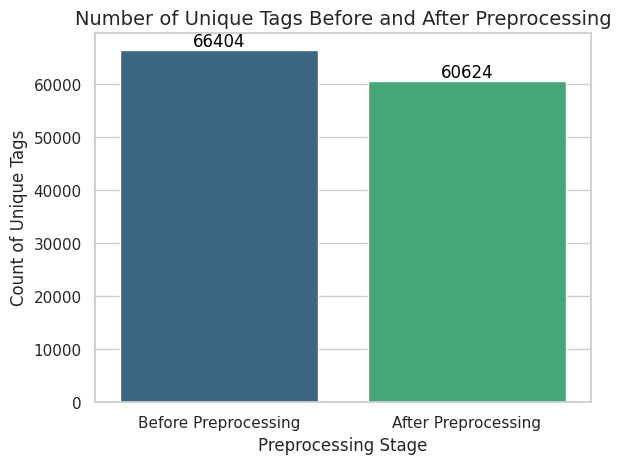

In [ ]:
def visualize_unique_tags_after_lemmatization():
  before_count = tags_df["tag"].nunique()
  after_count = new_tags_df["tag"].nunique()

  data = pd.DataFrame({
      'Stage': ['Before Preprocessing', 'After Preprocessing'],
      'Unique Tags': [before_count, after_count]
  })

  sns.set_theme(style="whitegrid")
  ax = sns.barplot(data=data, x='Stage', y='Unique Tags', palette='viridis')

  for p in ax.patches:
      ax.annotate(f'{int(p.get_height())}',  # Text with count
                  (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                  ha='center', va='bottom', fontsize=12, color='black')

  plt.title('Number of Unique Tags Before and After Preprocessing', fontsize=14)
  plt.xlabel('Preprocessing Stage', fontsize=12)
  plt.ylabel('Count of Unique Tags', fontsize=12)

plt.show()

visualize_unique_tags_after_lemmatization()

<ipython-input-14-4b7a3adf359f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='Stage', y='DataFrame Size', palette='viridis')


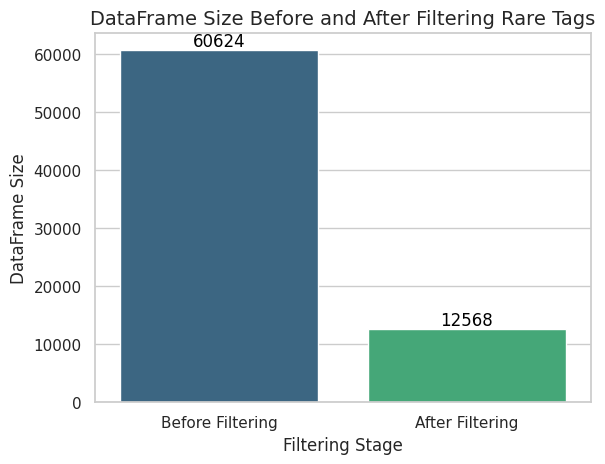

In [ ]:
# Calc tag counts
tag_counts = new_tags_df.tag.value_counts()

# Define the th for rare tags
rare_tags_threshold = 5

# Filter rare tags
filtered_tag_counts = tag_counts[tag_counts > rare_tags_threshold]

before_size = new_tags_df["tag"].nunique()
after_size = len(filtered_tag_counts)
data = pd.DataFrame({
    'Stage': ['Before Filtering', 'After Filtering'],
    'DataFrame Size': [before_size, after_size]
})

sns.set_theme(style="whitegrid")
ax = sns.barplot(data=data, x='Stage', y='DataFrame Size', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.title('DataFrame Size Before and After Filtering Rare Tags', fontsize=14)
plt.xlabel('Filtering Stage', fontsize=12)
plt.ylabel('DataFrame Size', fontsize=12)

plt.show()

## users with const rating

In [ ]:
# Group by 'movie_id' and calc mean and sd
x = train_df.groupby("movie_id")["rating"].agg(["mean","median", "std"])
x = x.sort_values(by=["mean", "std"], ascending=[False,True])

In [ ]:
# Calc the mean and standard deviation over all items
mean_rating = train_df["rating"].mean()
std_rating = train_df["rating"].std()

print("Mean rating over all items:", mean_rating)
print("Standard deviation over all items:", std_rating)

Mean rating over all items: 3.607693113434246
Standard deviation over all items: 1.0239529600335238


<ipython-input-17-6d4ed4db93ed>:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="user_id", y="rating", data=top_100_ratings, inner="quart", scale="count")


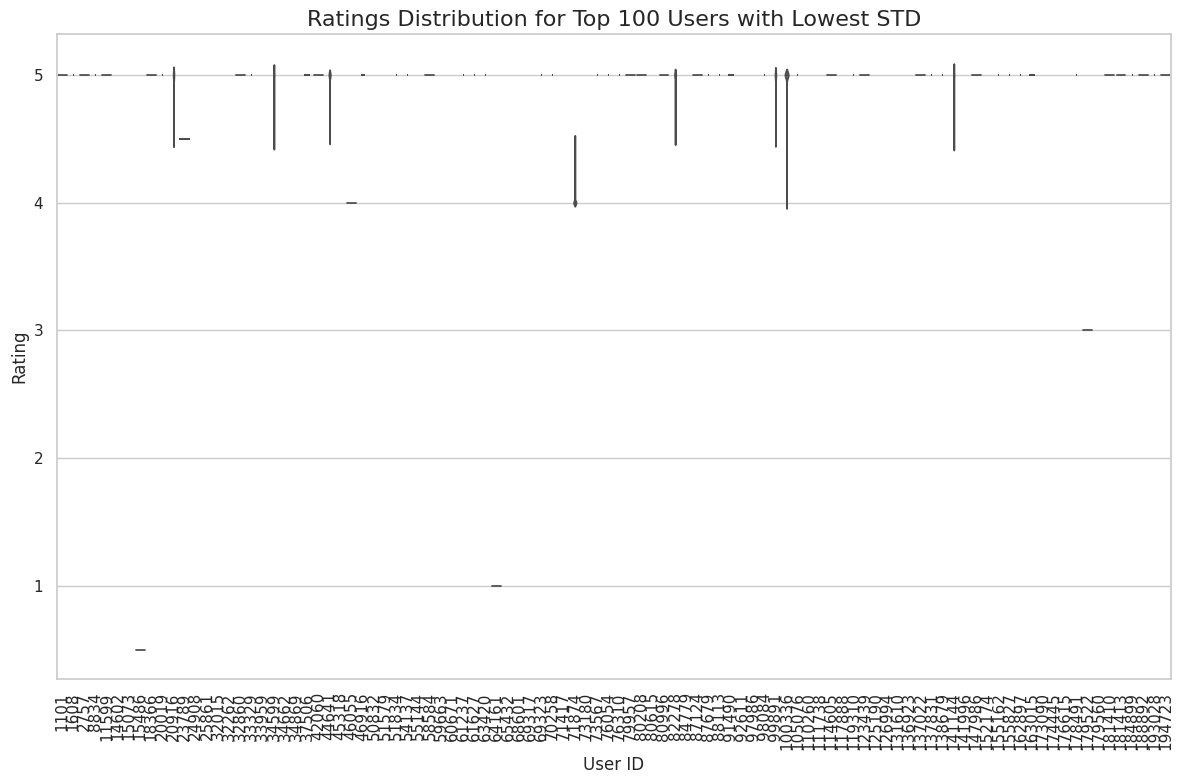

In [ ]:
# Group by 'user_id' and calc the sd
user_std = train_df.groupby("user_id")["rating"].std()

# Find the top 100 users with the lowest sd
top_100_users = user_std.nsmallest(100).index

# Filter data to include only the ratings from the top 100 users
top_100_ratings = train_df[train_df["user_id"].isin(top_100_users)]

plt.figure(figsize=(12, 8))
sns.violinplot(x="user_id", y="rating", data=top_100_ratings, inner="quart", scale="count")

plt.title("Ratings Distribution for Top 100 Users with Lowest STD", fontsize=16)
plt.xlabel("User ID", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Group by 'user_id' to find the unique ratings and the count of ratings for each user
user_rating_stats = train_df.groupby("user_id").agg(
    unique_ratings=("rating", "nunique"),
    rating_count=("rating", "size")
)

# Filter users who rated only a single score
single_score_users = user_rating_stats[user_rating_stats["unique_ratings"] == 1]

# Get the count of such users and the number of ratings they provided
single_score_users_count = single_score_users.shape[0]
single_score_users_ratings_count = single_score_users["rating_count"].sum()

print(f"Number of users who rated only a single score consistently: {single_score_users_count}")
print(f"Total number of ratings made by these users: {single_score_users_ratings_count}")

Number of users who rated only a single score consistently: 92
Total number of ratings made by these users: 10925


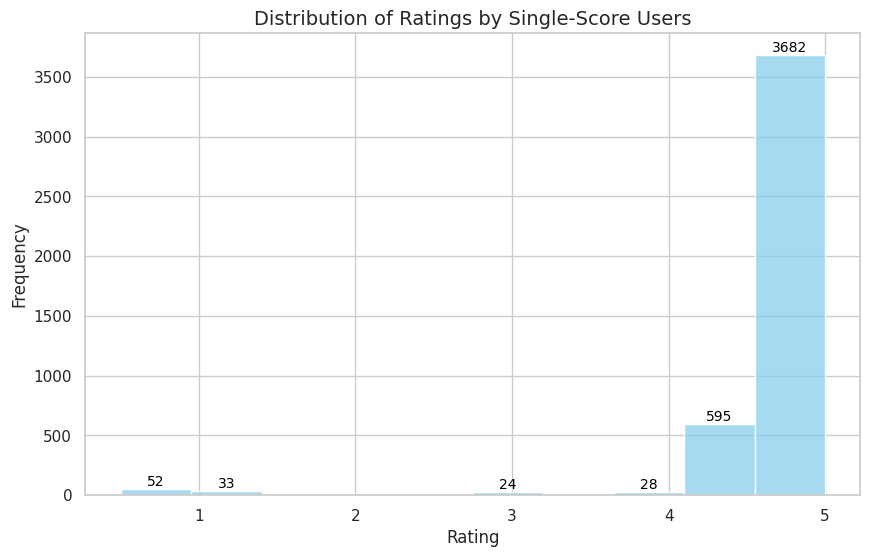

In [ ]:
# Extract repeated ratings for single-score users
single_score_ratings = train_df[train_df['user_id'].isin(single_score_users.index)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.histplot(single_score_ratings['rating'], bins=10, kde=False, color="skyblue")

plt.title('Distribution of Ratings by Single-Score Users', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

plt.show()

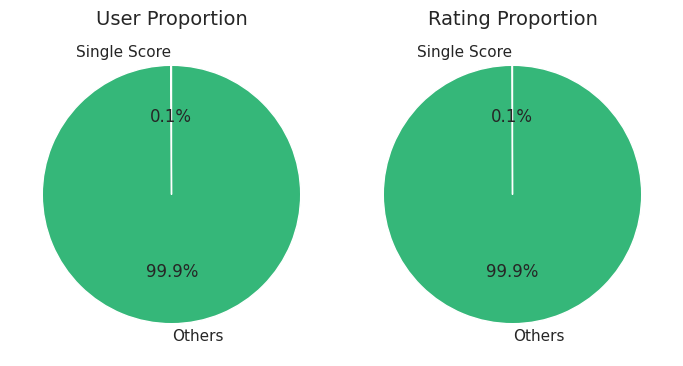

In [ ]:
total_users = train_df['user_id'].nunique()
total_ratings = train_df.shape[0]

users_data = [single_score_users_count, total_users - single_score_users_count]
ratings_data = [single_score_users_ratings_count, total_ratings - single_score_users_ratings_count]

labels = ['Single Score', 'Others']

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

axes[0].pie(users_data, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("viridis", 2), startangle=90)
axes[0].set_title('User Proportion', fontsize=14)

axes[1].pie(ratings_data, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("viridis", 2), startangle=90)
axes[1].set_title('Rating Proportion', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Group by 'user_id' to compute standard deviation and count of ratings for each user
user_rating_stats = train_df.groupby("user_id").agg(
    rating_std=("rating", "std"),
    rating_count=("rating", "size")
)

# Fill NaN
user_rating_stats['rating_std'] = user_rating_stats['rating_std'].fillna(0)

# Filter users with low sd
low_std_users = user_rating_stats[user_rating_stats["rating_std"] < 0.25]

# Get the count of such users and the num of ratings they provided
low_std_users_count = low_std_users.shape[0]
low_std_users_ratings_count = low_std_users["rating_count"].sum()

print(f"Number of users with low rating standard deviation (< 0.5): {low_std_users_count}")
print(f"Total number of ratings made by these users: {low_std_users_ratings_count}")

Number of users with low rating standard deviation (< 0.5): 205
Total number of ratings made by these users: 24504


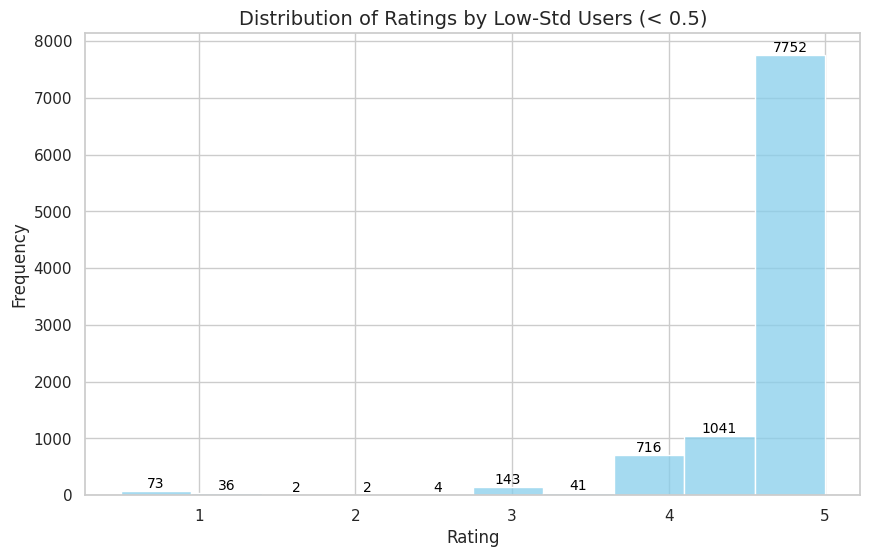

Total number of ratings made by low-std users: 24504


In [ ]:
# Extract ratings of low-standard-deviation users
low_std_user_ratings = train_df[train_df["user_id"].isin(low_std_users.index)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.histplot(low_std_user_ratings["rating"], bins=10, kde=False, color="skyblue")

plt.title('Distribution of Ratings by Low-Std Users (< 0.5)', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

plt.show()

total_ratings_low_std_users = low_std_user_ratings.shape[0]
print(f"Total number of ratings made by low-std users: {total_ratings_low_std_users}")

##Clustering

In [ ]:
unique_tags = new_tags_df['tag'].unique()
print("Number of unique tags:", len(unique_tags))

Number of unique tags: 60624


In [ ]:
# Load the pre-trained SentenceTransformer model
# Sentence transformers documentation for model performance
# https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

model_name = "all-mpnet-base-v2"
sentence_embedder = SentenceTransformer(model_name)

# Compute embeddings for the unique tags
tag_embeddings = sentence_embedder.encode(unique_tags)
print(f"Generated embeddings shape: {tag_embeddings.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generated embeddings shape: (60624, 768)


In [ ]:
num_clusters = 40

# Perform clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters_2 = kmeans.fit_predict(tag_embeddings)
clustered_tags_2 = pd.DataFrame({'tag': unique_tags, 'cluster': clusters_2})
print(clustered_tags_2.groupby('cluster').head())

                     tag  cluster
0               misogyny        7
1                  music       18
2                  weird       16
3               bullying        7
4                 clique        6
...                  ...      ...
1640       moving, shock       26
2254  cultural reference       33
3243     movie reference       33
3330  biblical reference       33
3951           reference       33

[200 rows x 2 columns]


Calculating WCSS for Clusters: 100%|██████████| 15/15 [03:06<00:00, 12.46s/it]


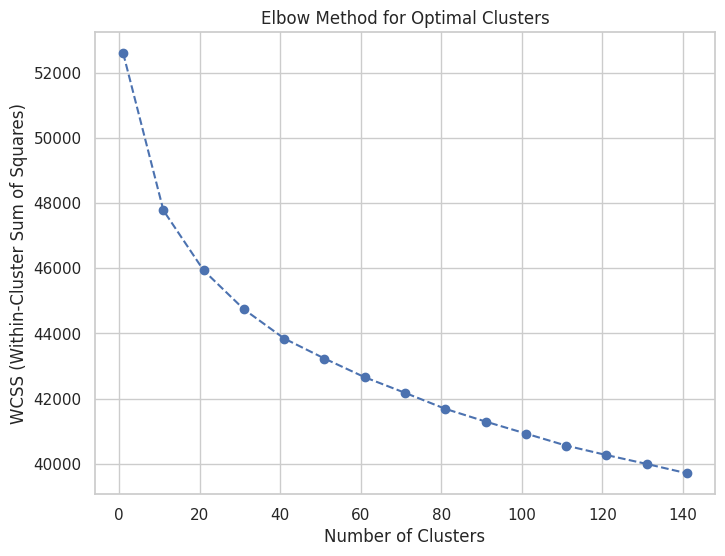

In [ ]:
wcss = []

# Calc WCSS
for num_clusters in tqdm(range(1, 150, 10), desc="Calculating WCSS for Clusters"):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tag_embeddings)
    wcss.append(kmeans.inertia_)  # WCSS is the inertia

# Visualize WCSS over number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 150, 10), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


Looking at the elbow method plot, the optimal number of clusters is where the Within-Cluster Sum of Squares begins to decrease more slowly, forming an "elbow" in the curve.

From this plot:

The elbow is around 40 clusters, as this is where the steep decline in WCSS starts to level off.

Beyond 40, the rate of decrease becomes less significant, indicating diminishing returns from adding more clusters.
Thus, 40 clusters appears to be the best choice for k according to the elbow method.

In [ ]:
# Display tags in each cluster
for cluster in range(40):
    print(f"\nCluster {cluster}:")
    tags_in_cluster = clustered_tags_2[clustered_tags_2['cluster'] == cluster]['tag']
    print(", ".join(tags_in_cluster.tolist()))


Cluster 0:
japanese influence, mar, misogony, korean, vangelis, franka potente, german, irish accent, german expressionism, americanise, caper, french, linguist, ana de armas, accent, language, atreyu, chinese humor, stasi, greek weird wave, mayra leal, cho yeo-jeong, liev shreiber, non sequitor, holiday, manicheaist, polyglot, silat, guinan, die antwoord, aronofski, la vega, imhotep, polynesian, southern accent, comedinha de velhinhos engraãƒâ§ada, del synnott, ming-na, soon-tek oh, han conried, ilse steppat, telly savalas, nona gaye, swedish, alien language, british accent, scottish accent, pinar toprak, iranium, avante-garde, nino rota, fairuza balk, gu van sant, yorkshire accent, urbane, frivilous, bad accent, stanislaw lem, international, pan-european, mariachi, italian, benedictcumberbatchbeinganasshole, greek, deutsch, lynchianoir, rasicm, muyahidin, polish resistance, partricia arquette, chliche, bilingual, spanish, ganska tam krigsrulle, dubbed, foreign language, spanish lang

In [ ]:
# Randomly sample a subset of tags
sampled_data = clustered_tags_2.sample(4000, random_state=42)
sampled_vectors = [tag_embeddings[i] for i in sampled_data.index]

In [ ]:
# Reduce dimensions with PCA first
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 dimensions
reduced_vectors = pca.fit_transform(sampled_vectors)

# Apply t-SNE on reduced data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(reduced_vectors)

<ipython-input-43-1b97bf29fc7a>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



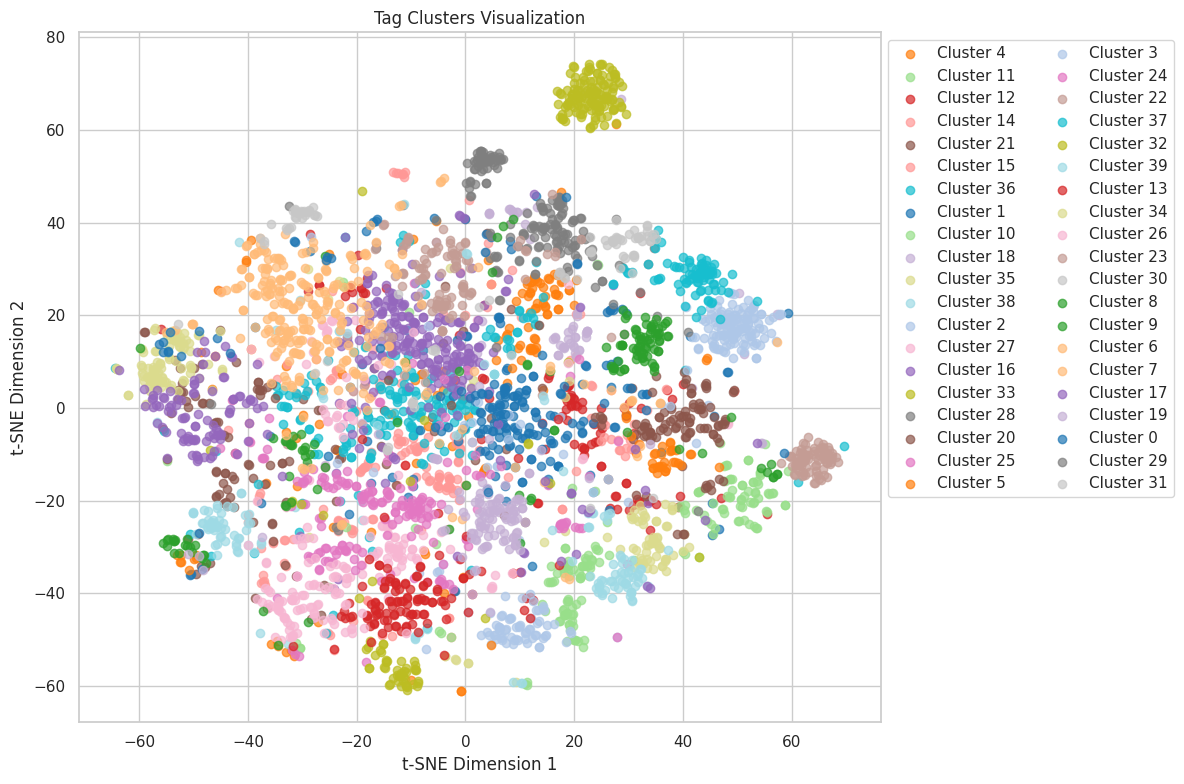

In [ ]:
colormap = plt.cm.get_cmap('tab20', 40)

sampled_data['tsne_x'] = reduced_tsne[:, 0]  # Add t-SNE x-coordinates
sampled_data['tsne_y'] = reduced_tsne[:, 1]  # Add t-SNE y-coordinates

plt.figure(figsize=(12, 8))
for cluster_id in sampled_data['cluster'].unique():
    cluster_points = sampled_data[sampled_data['cluster'] == cluster_id]
    plt.scatter(
        cluster_points['tsne_x'],
        cluster_points['tsne_y'],
        label=f'Cluster {cluster_id}',
        color=colormap(cluster_id),
        alpha=0.7
    )

plt.title('Tag Clusters Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best', ncol=2, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30).fit_transform(reduced_vectors)

In [ ]:
sampled_data['tsne_x'] = tsne_3d[:, 0]
sampled_data['tsne_y'] = tsne_3d[:, 1]
sampled_data['tsne_z'] = tsne_3d[:, 2]

In [ ]:
colormap = get_cmap('tab20', 40)
colors = [f'rgba({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)},1)' for c in colormap.colors]

#Map colors to clusters
cluster_ids = range(40)
color_map = {cluster_id: colors[cluster_id % len(colors)] for cluster_id in cluster_ids}


fig = go.Figure()

for cluster_id in cluster_ids:
    cluster_points = sampled_data[sampled_data['cluster'] == cluster_id]

    if not cluster_points.empty:
        fig.add_trace(go.Scatter3d(
            x=cluster_points['tsne_x'],
            y=cluster_points['tsne_y'],
            z=cluster_points['tsne_z'],
            mode='markers',
            marker=dict(size=5, color=color_map[cluster_id]),
            name=f'Cluster {cluster_id}'
        ))
    else:
        fig.add_trace(go.Scatter3d(
            x=[None],
            y=[None],
            z=[None],
            mode='markers',
            marker=dict(size=5, color=color_map[cluster_id]),
            name=f'Cluster {cluster_id}'
        ))

fig.update_layout(
    title='3D Tag Clusters Visualization',
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    legend=dict(
        itemsizing='constant',
        title='Clusters',
        bgcolor="rgba(240,240,240,0.5)"
    )
)

fig.show()

<ipython-input-61-ef2feef7b07d>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

